# Categorical and quantitative data - hyperparameter tuning - Logistic Regression

### Techniques covered in this Notebook
- Preprocessing the categorical and quantitative data (excludes connectome matrices / MRI images)
- Logistic Regression
- Hyperparameter tuning
- Threshold optimisation
- Feature importance

In [71]:
import numpy as np
import pandas as pd
import csv
import openpyxl
import matplotlib.pyplot as plt
import seaborn as sns
import time 
from sklearn.linear_model import LogisticRegression
from itertools import product
from sklearn.utils import class_weight
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
import warnings

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

## Load the data

In [72]:
# Set model family name  no features excluded,  not applied in this version
model_family = 'LogReg_thresh_0_3_0_7_(100)_feat_mod7b'

Specify data input folder

In [73]:
# SET FOLDERS (LOCAL OR REMOTE - COLAB COVERED IN THIS CELL)

# Local folders 
data_input_folder = '../data'
output_folder = '../data/Interim'


# Colab 
# Mount drive 
#from google.colab import drive
#drive.mount('/content/drive')

# Set Colab folders
# data_input_folder = '/content/drive/MyDrive/WIDS_2025'
# output_folder = '/content/drive/MyDrive/WIDS_2025/Output'

Load training data

In [ ]:
# Start runtime measurement
start_time                 = time.time()

# Load categorical data as category:
train_cat_features_input   = pd.read_excel(f"{data_input_folder}/TRAIN_NEW/TRAIN_CATEGORICAL_METADATA_new.xlsx")
train_cat_features_input.sort_values(by='participant_id', inplace=True)

# Load additional categorical variables (extracted from connectome matrices)
cat_add_columns            = ['participant_id', 'avg_above_overall_avg']
train_cat_features_add     = pd.read_csv(f"{data_input_folder}/Interim/connectome_averages_TRAIN.csv")[cat_add_columns]
train_cat_features_add.sort_values(by='participant_id', inplace=True)

# Merge categorical features:
train_cat_features         = pd.merge(train_cat_features_input, train_cat_features_add, on='participant_id', how='left')
train_cat_features         = train_cat_features.astype('category')

# Load quantitative data:
train_quant_features_input = pd.read_excel(f"{data_input_folder}/TRAIN_NEW/TRAIN_QUANTITATIVE_METADATA_new.xlsx")
train_quant_features_input.sort_values(by='participant_id', inplace=True)

# Load additional quantitative variables (extracted from connectome matrices)
quant_add_columns          = ['participant_id', 'nr_of_cells_above_cell_avg', 'nr_of_cells_above_overall_avg', 'non_diagonal_diffs']
train_quant_features_add   = pd.read_csv(f"{data_input_folder}/Interim/connectome_averages_TRAIN.csv")[quant_add_columns]
train_quant_features_add.sort_values(by='participant_id', inplace=True)

# Merge quantitative features:
train_quant_features         = pd.merge(train_quant_features_input, train_quant_features_add, on='participant_id', how='left')
#train_quant_features         = train_quant_features.astype('category')

# Load solutions:
solution                   = pd.read_excel(f"{data_input_folder}/TRAIN_NEW/TRAINING_SOLUTIONS.xlsx")
solution.sort_values(by='participant_id', inplace=True)
solution                   = solution.astype('category') 

train_merged               = pd.merge(train_cat_features, train_quant_features, on='participant_id', how='left')
train_merged               = pd.merge(train_merged, solution, on='participant_id', how='left')

# Dictionary of training data
train                      = {'mode': 'train',
                              'cat': train_cat_features,
                              'quant': train_quant_features,
                              'solution': solution,
                              'merged': train_merged}

Load test data

In [75]:
# Load categorical data as category:
test_cat_features_input   = pd.read_excel(f"{data_input_folder}/TEST/TEST_CATEGORICAL.xlsx")

# Load additional categorical variables (extracted from connectome matrices)
test_cat_features_add     = pd.read_csv(f"{data_input_folder}/Interim/connectome_averages_TEST.csv")[cat_add_columns]
test_cat_features_add.sort_values(by='participant_id', inplace=True)

# Merge categorical features:
test_cat_features         = pd.merge(test_cat_features_input, test_cat_features_add, on='participant_id', how='left')
test_cat_features         = test_cat_features.astype('category')

# Load quantitative data:
test_quant_features_input = pd.read_excel(f"{data_input_folder}/TEST/TEST_QUANTITATIVE_METADATA.xlsx")

# Load additional quantitative variables (extracted from connectome matrices)
test_quant_features_add     = pd.read_csv(f"{data_input_folder}/Interim/connectome_averages_TEST.csv")[quant_add_columns]
test_quant_features_add.sort_values(by='participant_id', inplace=True)

# Merge quantitative features:
test_quant_features         = pd.merge(test_quant_features_input, test_quant_features_add, on='participant_id', how='left')


# Merge datasets into one:
test_merged               = pd.merge(test_cat_features, test_quant_features, on='participant_id', how='left')

# Dictionary of training data
test                      = {'mode': 'TEST',
                             'cat': test_cat_features,
                             'quant': test_quant_features,
                             'solution': None,
                             'merged': test_merged}

## Set parameters

Set parameters for data preprocessing

In [ ]:
data_preproc_params = {}

# Full list of 9 categorical variables:
#   Basic_Demos_Enroll_Year, Basic_Demos_Study_Site, PreInt_Demos_Fam_Child_Ethnicity, PreInt_Demos_Fam_Child_Race,	
#   MRI_Track_Scan_Location, Barratt_Barratt_P1_Edu, Barratt_Barratt_P1_Occ,           Barratt_Barratt_P2_Edu',      Barratt_Barratt_P2_Occ

# Full list of 18 quantitatigve variables:
#   EHQ_EHQ_Total,	            ColorVision_CV_Score,  APQ_P_APQ_P_CP,	          APQ_P_APQ_P_ID,	         APQ_P_APQ_P_INV,   
#   APQ_P_APQ_P_OPD	            APQ_P_APQ_P_PM,	       APQ_P_APQ_P_PP	          SDQ_SDQ_Conduct_Problems,	 SDQ_SDQ_Difficulties_Total, 
#   SDQ_SDQ_Emotional_Problems	SDQ_SDQ_Externalizing, SDQ_SDQ_Generating_Impact, SDQ_SDQ_Hyperactivity	     SDQ_SDQ_Internalizing	
#   SDQ_SDQ_Peer_Problems,      SDQ_SDQ_Prosocial,     MRI_Track_Age_at_Scan

data_preproc_params['cat_columns_to_drop']   = ['Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site', 'MRI_Track_Scan_Location']
#                                                'Barratt_Barratt_P1_Edu', 'Barratt_Barratt_P2_Edu', 'PreInt_Demos_Fam_Child_Ethnicity']
data_preproc_params['quant_columns_to_drop'] = [] #'SDQ_SDQ_Conduct_Problems', 'APQ_P_APQ_P_OPD', 'SDQ_SDQ_Peer_Problems','APQ_P_APQ_P_CP']

# Specify if Principal Component Analysis (PCA) should be used for dimension reduction for quantitative features and connectome matrices:
# If yes specify the number of principal components
data_preproc_params['apply_pca_quant']                       = False
data_preproc_params['nr_pca_components_quant']               = 2

# Set imputer methods:
data_preproc_params['categorical_imputer_strategy']          = 'most_frequent'         # Options: 'most frequent' 

data_preproc_params['numeric_imputer']                       = 'iterative'             # Options: 'iterative' or 'simple'
                                                                                       # In case 'iterative' selected then a RF regression will be performed
data_preproc_params['numeric_imputer_strategy']              = None                    # Options for simple: 'median', 'mean', 'most freqent', 'constant'
                                                                          # No options for iterative

Set model hyperparameters

In [77]:
# Range for 
threshold_range = np.linspace(0.3, 0.7, 21)

model_param_ranges = {
    'sex': {
        'C': [0.01, 0.1, 1.0, 10.0],  # Regularization strength
        'penalty': ['l2'],            # Usually stick with 'l2'
        'solver': ['lbfgs'],          # Works for binary classification
        'max_iter': [100, 200],       # Just in case it needs more iterations
    },

    'adhd': {
        'C': [0.01, 0.1, 1.0, 10.0],  # Regularization strength
        'penalty': ['l2'],            # Usually stick with 'l2'
        'solver': ['lbfgs'],          # Works for binary classification
        'max_iter': [100, 200],       # Just in case it needs more iterations                        
    }
}


Set model evaluation parameters

In [78]:
# Number of folds (k) for k-fold cross-validation:
nr_of_folds      = 5 

## Data preprocessing

Define Principal Component Analysis (PCA)

In [79]:
def drop_columns(data, data_preproc_params):
    
    mode = data['mode']

    # Merge categorical and quantitative columns to drop (no columns dropped from connectome matrix):
    cat_columns_to_drop = data_preproc_params['cat_columns_to_drop']
    quant_columns_to_drop = data_preproc_params['quant_columns_to_drop']

    # Drop selected columns for categorical and quantitative data:
    data['cat'] = data['cat'].drop(cat_columns_to_drop, axis=1)
    data['quant'] = data['quant'].drop(quant_columns_to_drop, axis=1)

    # Merge cat and quant
    data['merged'] = pd.merge(data['cat'], data['quant'], on='participant_id', how='left')

    # Merge solution in TRAIN mode only
    if mode == 'TRAIN':
        solution = data['solution']  # <-- important!
        data['merged'] = pd.merge(data['merged'], solution, on='participant_id', how='left')

    return data

In [80]:
def preprocess_data_fit(data, data_preproc_params):
    """
    Perform data preprocessing on training or test data.
    If training, includes PCA fitting.
    """
    apply_pca_quant = data_preproc_params['apply_pca_quant']
    nr_pca_components_quant = data_preproc_params['nr_pca_components_quant']

    # Retrieved merged data
    data_merged = data['merged']

    # Drop participant id and target columns
    X = data_merged.drop(['participant_id', 'ADHD_Outcome', 'Sex_F'], axis=1, errors='ignore')

    # Identify feature types
    categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_features = X.select_dtypes(exclude=['object', 'category']).columns.tolist()

    # Get imputers
    numeric_imputer = data_preproc_params['numeric_imputer']
    numeric_imputer_strategy = data_preproc_params['numeric_imputer_strategy']
    categorical_imputer_strategy = data_preproc_params['categorical_imputer_strategy']

    # Numeric pipeline steps list
    numeric_transformer_steps = [
        ('imputer', SimpleImputer(strategy=numeric_imputer_strategy)),
        ('scaler', StandardScaler())
    ] if numeric_imputer == 'simple' else [
        ('imputer', IterativeImputer(random_state=0)),
        ('scaler', StandardScaler())
    ]

    # Add PCA to the numeric pipeline steps list if PCA is required
    if apply_pca_quant:
        numeric_transformer_steps.append(('pca', PCA(n_components=nr_pca_components_quant)))

    # Create the numeric pipeline with the updated steps
    numeric_transformer = Pipeline(steps=numeric_transformer_steps)

    # Categorical pipeline (only imputing missing values, no one-hot encoding)
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy=categorical_imputer_strategy))
        # No OneHotEncoder here anymore
    ])

    # Full preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )

    # Fit preprocessor on training data
    preprocessor.fit(X)

    # After preprocessing, numerical features are scaled (and PCA'd optionally)
    # and categorical features are still intact (just missing values filled)
    # So feature names are just numerical + categorical original names

    return preprocessor


In [81]:
def preprocess_data_transform(data, preprocessor):
    """
    Apply data preprocessing (including PCA transformation if requested) to data.
    Uses the provided preprocessor and applies transformations.
    """
    # Preprocess data with the provided preprocessor
    data_merged = data['merged']
    
    # Ensure you select the correct features based on your ColumnTransformer
    X = data_merged.drop(['participant_id', 'ADHD_Outcome', 'Sex_F'], axis=1, errors='ignore')

    # Apply preprocessing (numeric and categorical transformations)
    data_transformed = preprocessor.transform(X)
    
    # Convert the transformed data to a DataFrame
    data_transformed_df = pd.DataFrame(
        data_transformed, 
        index=X.index,
        columns=preprocessor.get_feature_names_out()
    )

    print('Data transformed df cols:', data_transformed_df.columns)
    print('Data transformed df shape:', data_transformed_df.shape)

    # No need for PCA application here since it's done in preprocessing

    return data_transformed_df

Drop unused columns

In [82]:
train                               = drop_columns(train, data_preproc_params)
test                                = drop_columns(test, data_preproc_params)

Perform data preprocessing (fit preprocessor and perform PCA if required)

In [83]:
preprocessor = preprocess_data_fit(train, data_preproc_params)

Perform data transformation to prepare data for training

In [84]:
X_preprocessed_train                = preprocess_data_transform(train, preprocessor)
X_preprocessed_test                 = preprocess_data_transform(test, preprocessor)

Data transformed df cols: Index(['num__EHQ_EHQ_Total', 'num__ColorVision_CV_Score',
       'num__APQ_P_APQ_P_CP', 'num__APQ_P_APQ_P_ID', 'num__APQ_P_APQ_P_INV',
       'num__APQ_P_APQ_P_OPD', 'num__APQ_P_APQ_P_PM', 'num__APQ_P_APQ_P_PP',
       'num__SDQ_SDQ_Conduct_Problems', 'num__SDQ_SDQ_Difficulties_Total',
       'num__SDQ_SDQ_Emotional_Problems', 'num__SDQ_SDQ_Externalizing',
       'num__SDQ_SDQ_Generating_Impact', 'num__SDQ_SDQ_Hyperactivity',
       'num__SDQ_SDQ_Internalizing', 'num__SDQ_SDQ_Peer_Problems',
       'num__SDQ_SDQ_Prosocial', 'num__MRI_Track_Age_at_Scan',
       'num__nr_of_cells_above_cell_avg', 'num__nr_of_cells_above_overall_avg',
       'num__non_diagonal_diffs', 'cat__PreInt_Demos_Fam_Child_Ethnicity',
       'cat__PreInt_Demos_Fam_Child_Race', 'cat__Barratt_Barratt_P1_Edu',
       'cat__Barratt_Barratt_P1_Occ', 'cat__Barratt_Barratt_P2_Edu',
       'cat__Barratt_Barratt_P2_Occ', 'cat__avg_above_overall_avg'],
      dtype='object')
Data transformed df shape

## Model training and hyperparameter tuning

Define weighted F1 score (evaluation metric specified in the Datathon where females have double weight for ADHD prediction)

In [85]:
def get_weighted_f1(y_true, y_pred, sex, female_weight = 2.0, male_weight = 1.0):

    sample_weight = np.where(sex == 1, female_weight, male_weight)
    return f1_score(y_true, y_pred, average='binary', sample_weight=sample_weight)

### Train model on a grid of hyperparameters and select the best model (highest F1 score)

Define function for hyperparameter tuning and model selection

In [86]:
def select_best_model(X_preprocessed_train, y_actual, nr_of_folds, model_param_ranges,
                      target, y_true_sex=None):

    best_metric = -1
    best_model = None
    best_params = None
    best_oof_probs = None
    fixed_threshold = 0.5

    # Expand any dicts like {'min': 1, 'max': 10, 'step': 1} into lists
    keys = list(model_param_ranges[target].keys())
    values = []
    for v in model_param_ranges[target].values():
        if isinstance(v, dict):
            values.append(list(range(v['min'], v['max'] + 1, v['step'])))
        else:
            values.append(v)

    # Cartesian product of all parameter combinations
    param_grid = [dict(zip(keys, combo)) for combo in product(*values)]

    skf = StratifiedKFold(n_splits=nr_of_folds, shuffle=True, random_state=42)

    for i, param_combo in enumerate(param_grid, start=1):

        oof_preds = np.zeros(len(y_actual))

        for train_idx, val_idx in skf.split(X_preprocessed_train, y_actual):
            X_train, X_val = X_preprocessed_train.iloc[train_idx], X_preprocessed_train.iloc[val_idx]
            y_train, y_val = y_actual.iloc[train_idx], y_actual.iloc[val_idx]

            model = LogisticRegression(**param_combo)
            model.fit(X_train, y_train)

            preds = model.predict_proba(X_val)[:, 1]
            oof_preds[val_idx] = preds

        y_pred = (oof_preds > fixed_threshold).astype(int)

        if target == 'adhd':
            metric = get_weighted_f1(y_actual, y_pred, y_true_sex)
        else:
            metric = f1_score(y_actual, y_pred)

        if metric > best_metric:
            best_metric = metric
            best_model = model  # Use the model from the cross-validation loop
            best_params = param_combo
            best_oof_probs = oof_preds

        if i % 50 == 0:
            print(f"{i} parameter combinations processed for {target} model selection | Best F1: {best_metric:.4f}")

    best_params['fixed_threshold'] = fixed_threshold
    return best_model, best_metric, best_params, best_oof_probs

Set ADHD and set models to the best ones. Note that the best F1 scores here are not the final ones as they were calculated using a prediction threshold of 0.5 (to be optimised in the following step)

In [87]:
# Specify actual labels:
y_actual_sex  = train_merged['Sex_F'].astype(int)  # Ensure this aligns 100% with X_preprocessed_train
y_actual_adhd = train_merged['ADHD_Outcome'].astype(int)  # Ensure this aligns 100% with X_preprocessed_train

# Train sex model first
sex_model, best_f1_sex, best_params_sex, best_oof_probs_sex = select_best_model(
    X_preprocessed_train, y_actual_sex, nr_of_folds, model_param_ranges, target='sex')

# Then ADHD model
adhd_model,  best_f1_adhd, best_params_adhd, best_oof_probs_adhd = select_best_model(
    X_preprocessed_train, y_actual_adhd, nr_of_folds, model_param_ranges, target='adhd',
    y_true_sex = y_actual_sex)

Print interim best F1 scores (with prediction threshold = 0.5)

In [88]:
print('Best interim F1 score for ADHD - weighted with double weights for females: ', round(best_f1_adhd, 4))
print('Best interim F1 score for Sex - unweighted: ', round(best_f1_sex, 4))

Best interim F1 score for ADHD - weighted with double weights for females:  0.8616
Best interim F1 score for Sex - unweighted:  0.3616


Find best threshold for prediction:

In [89]:
def find_best_threshold(y_true, best_oof_probs, target, y_true_sex=None):
    thresholds = threshold_range
    metrics = []

    for t in thresholds:
        y_pred = (best_oof_probs > t).astype(int)
        metric = (
            f1_score(y_true, y_pred) if target == 'sex'
            else get_weighted_f1(y_true, y_pred, y_true_sex)
        )
        metrics.append(metric)

    best_idx = np.argmax(metrics)
    return thresholds[best_idx], metrics[best_idx]


Print highest F1 scores and corresponding thresholds

ADHD

In [90]:
# Determine best threshold and best F1 score
best_threshold_adhd, best_f1_score_adhd = find_best_threshold(y_actual_adhd, best_oof_probs_adhd, 'adhd', y_actual_sex)

print(f'For ADHD prediction the best prediction threshold is {best_threshold_adhd}')
print(f'Highest F1 score for sex ADHD with {model_family}: {round(best_f1_score_adhd, 4)}\n')
for param, value in best_params_adhd.items():
    print(f"  {param}: {value}")

For ADHD prediction the best prediction threshold is 0.48
Highest F1 score for sex ADHD with LogReg_thresh_0_3_0_7_(100)_feat_mod7b: 0.8632

  C: 10.0
  penalty: l2
  solver: lbfgs
  max_iter: 100
  fixed_threshold: 0.5


Sex

In [91]:
# Determine best threshold for Sex
best_threshold_sex, best_f1_score_sex = find_best_threshold(y_actual_sex, best_oof_probs_sex, 'sex')
print(f'For sex prediction the best prediction threshold is {best_threshold_sex}')
print(f'Highest F1 score for sex with {model_family}: {round(best_f1_score_sex, 4)}]\n')
for param, value in best_params_sex.items():
    print(f"  {param}: {value}")

For sex prediction the best prediction threshold is 0.33999999999999997
Highest F1 score for sex with LogReg_thresh_0_3_0_7_(100)_feat_mod7b: 0.523]

  C: 10.0
  penalty: l2
  solver: lbfgs
  max_iter: 100
  fixed_threshold: 0.5


## Feature importance

ADHD

In [92]:
adhd_feature_importances = np.abs(adhd_model.coef_[0])
adhd_feature_names = X_preprocessed_train.columns  

adhd_importance_df = pd.DataFrame({
    'feature': adhd_feature_names,
    'importance': adhd_feature_importances
}).sort_values('importance', ascending=False)

print(adhd_importance_df)

                                  feature  importance
13             num__SDQ_SDQ_Hyperactivity    1.040635
11             num__SDQ_SDQ_Externalizing    0.534891
8           num__SDQ_SDQ_Conduct_Problems    0.351864
12         num__SDQ_SDQ_Generating_Impact    0.339620
20                num__non_diagonal_diffs    0.318149
17             num__MRI_Track_Age_at_Scan    0.309959
9         num__SDQ_SDQ_Difficulties_Total    0.306707
21  cat__PreInt_Demos_Fam_Child_Ethnicity    0.279914
10        num__SDQ_SDQ_Emotional_Problems    0.213015
5                    num__APQ_P_APQ_P_OPD    0.127875
15             num__SDQ_SDQ_Peer_Problems    0.120186
27             cat__avg_above_overall_avg    0.109334
19     num__nr_of_cells_above_overall_avg    0.106804
6                     num__APQ_P_APQ_P_PM    0.106529
1               num__ColorVision_CV_Score    0.097910
4                    num__APQ_P_APQ_P_INV    0.092522
18        num__nr_of_cells_above_cell_avg    0.091550
2                     num__A

Sex

In [93]:
sex_feature_importances = np.abs(sex_model.coef_[0])
sex_feature_names = X_preprocessed_train.columns  

sex_importance_df = pd.DataFrame({
    'feature': sex_feature_names,
    'importance': sex_feature_importances
}).sort_values('importance', ascending=False)

print(sex_importance_df)

                                  feature  importance
13             num__SDQ_SDQ_Hyperactivity    0.360395
10        num__SDQ_SDQ_Emotional_Problems    0.350350
1               num__ColorVision_CV_Score    0.283308
17             num__MRI_Track_Age_at_Scan    0.266590
16                 num__SDQ_SDQ_Prosocial    0.222237
18        num__nr_of_cells_above_cell_avg    0.213749
27             cat__avg_above_overall_avg    0.206164
11             num__SDQ_SDQ_Externalizing    0.190582
14             num__SDQ_SDQ_Internalizing    0.180128
7                     num__APQ_P_APQ_P_PP    0.165008
19     num__nr_of_cells_above_overall_avg    0.149219
4                    num__APQ_P_APQ_P_INV    0.135781
3                     num__APQ_P_APQ_P_ID    0.132984
8           num__SDQ_SDQ_Conduct_Problems    0.110959
2                     num__APQ_P_APQ_P_CP    0.108607
6                     num__APQ_P_APQ_P_PM    0.106238
12         num__SDQ_SDQ_Generating_Impact    0.086170
21  cat__PreInt_Demos_Fam_Ch

Distinguish between important and not important features

In [94]:
# First, add cumulative importance columns
adhd_importance_df['cumulative_importance'] = adhd_importance_df['importance'].cumsum() / adhd_importance_df['importance'].sum()
sex_importance_df['cumulative_importance']  = sex_importance_df['importance'].cumsum() / sex_importance_df['importance'].sum()

# Select features that contribute to >90% of importance
adhd_important_features = adhd_importance_df[adhd_importance_df['cumulative_importance'] <= 0.90]['feature'].tolist()
sex_important_features  = sex_importance_df[sex_importance_df['cumulative_importance']  <= 0.90]['feature'].tolist()

# Print kept features
print("Important features for ADHD prediction (>90% importance):")
print(adhd_important_features)

print("\nImportant features for Sex prediction (>90% importance):")
print(sex_important_features)

# Now create a list of features to drop:
# Features that are NOT important for either ADHD or Sex prediction

# Combine all features
all_features = set(adhd_importance_df['feature'].tolist()) | set(sex_importance_df['feature'].tolist())

# Features that are important for either ADHD or Sex
important_features = set(adhd_important_features) | set(sex_important_features)

# Features to drop = features not in important_features
features_to_drop = list(all_features - important_features)

print("\nFeatures to drop (not important for either):")
print(features_to_drop)

Important features for ADHD prediction (>90% importance):
['num__SDQ_SDQ_Hyperactivity', 'num__SDQ_SDQ_Externalizing', 'num__SDQ_SDQ_Conduct_Problems', 'num__SDQ_SDQ_Generating_Impact', 'num__non_diagonal_diffs', 'num__MRI_Track_Age_at_Scan', 'num__SDQ_SDQ_Difficulties_Total', 'cat__PreInt_Demos_Fam_Child_Ethnicity', 'num__SDQ_SDQ_Emotional_Problems', 'num__APQ_P_APQ_P_OPD', 'num__SDQ_SDQ_Peer_Problems', 'cat__avg_above_overall_avg', 'num__nr_of_cells_above_overall_avg', 'num__APQ_P_APQ_P_PM', 'num__ColorVision_CV_Score', 'num__APQ_P_APQ_P_INV', 'num__nr_of_cells_above_cell_avg']

Important features for Sex prediction (>90% importance):
['num__SDQ_SDQ_Hyperactivity', 'num__SDQ_SDQ_Emotional_Problems', 'num__ColorVision_CV_Score', 'num__MRI_Track_Age_at_Scan', 'num__SDQ_SDQ_Prosocial', 'num__nr_of_cells_above_cell_avg', 'cat__avg_above_overall_avg', 'num__SDQ_SDQ_Externalizing', 'num__SDQ_SDQ_Internalizing', 'num__APQ_P_APQ_P_PP', 'num__nr_of_cells_above_overall_avg', 'num__APQ_P_APQ_P_

## Model Evaluation

### Model Evaluation - ADHD

Model performance (ADHD)

In [95]:
# Use predicted labels from model
y_true              = y_actual_adhd
y_true_sex          = y_actual_sex
best_oof_preds_adhd = (best_oof_probs_adhd> best_threshold_adhd).astype(int)
y_pred              = best_oof_preds_adhd 

# Flatten if needed
y_true = np.ravel(y_true)
y_pred = np.ravel(y_pred)

# Metrics 
# Note: for weighted F1, the sex target variable is used (as per competition rules, in the ADHD F1 score females have double weight)
weighted_f1 = get_weighted_f1(y_true, y_pred, y_true_sex)
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)

# Output
print("Weighted F1 score:", round(weighted_f1, 4))
print("F1 score:", round(f1, 4))
print("Precision:", round(precision, 4))
print("Recall:", round(recall, 4))
print("Accuracy:", round(accuracy, 4))

Weighted F1 score: 0.8632
F1 score: 0.8695
Precision: 0.8326
Recall: 0.9097
Accuracy: 0.8129


Confusion matrix (ADHD)

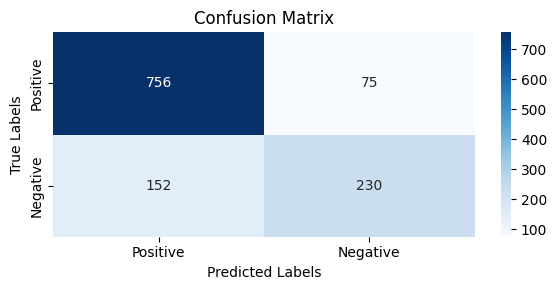

In [96]:
# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Optional: [TP, FN], [FP, TN] format
# If you want to follow your previous manual format:
conf_matrix = np.array([[cm[1,1], cm[1,0]],
                        [cm[0,1], cm[0,0]]])

# Plot
cm_labels = ['Positive', 'Negative']
categories = ['Positive', 'Negative']
plt.figure(figsize=(6, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=cm_labels, yticklabels=categories)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()

### Model Evaluation - Sex model (best)

Model performance

In [97]:
# Set sex predictions on the validation set based on the optimised (best) threshold and probabilities
y_true             = y_true_sex
best_oof_preds_sex = (best_oof_probs_sex > best_threshold_sex).astype(int)
y_pred             = best_oof_preds_sex  

# Metrics
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)

# Output
print("F1 score:", round(f1, 4))
print("Precision:", round(precision, 4))
print("Recall:", round(recall, 4))
print("Accuracy:", round(accuracy, 4))

F1 score: 0.523
Precision: 0.4471
Recall: 0.6298
Accuracy: 0.6059


Confusion matrix

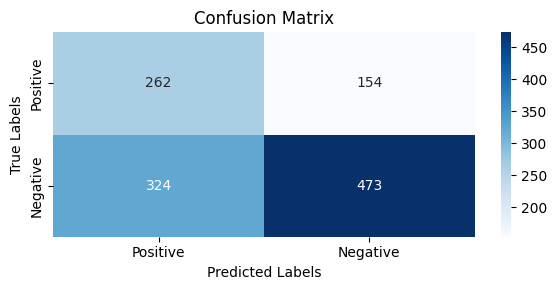

In [98]:
# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Optional: [TP, FN], [FP, TN] format
# If you want to follow your previous manual format:
conf_matrix = np.array([[cm[1,1], cm[1,0]],
                        [cm[0,1], cm[0,0]]])

# Plot
cm_labels = ['Positive', 'Negative']
categories = ['Positive', 'Negative']

plt.figure(figsize=(6, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=cm_labels, yticklabels=categories)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()


## Prediction on the training validation set (for meta classification)

Include ADHD predictions and probabilities on the trainig validation dataset in a pandas dataframe and save to a csv file.

print(solution.head())

In [99]:
participant_id_train = solution.index

train_pred_prob_df = pd.DataFrame({
    'participant_id': participant_id_train,  # This should be your patient_id array
    'pred_sex': best_oof_preds_sex, 
    'prob_sex': best_oof_probs_sex, 
    'pred_adhd': best_oof_preds_adhd,  
    'prob_adhd': best_oof_probs_adhd  
})

# Save to CSV
train_pred_prob_df.to_csv(f"{output_folder}/{model_family}_train_pred_prob.csv", index=False)

## Prediction on the test set

Evaluate model on the test data

In [100]:
# Calculate probabilities of belonging to a certain class on the training data
y_probs_test_sex = sex_model.predict_proba(X_preprocessed_test)[:, 1]
y_probs_test_adhd = adhd_model.predict_proba(X_preprocessed_test)[:, 1]

# Use probabilities to perform model prediction on the training data
y_pred_test_sex = (y_probs_test_sex > best_threshold_sex).astype(int)
y_pred_test_adhd = (y_probs_test_adhd> best_threshold_adhd).astype(int)

# Retrieve participant id from the training data
test_cat            = test['cat']
participant_id_test = test_cat['participant_id']

# Check first 10 predicted probabilities for sex model
print("First 10 predicted probabilities (Sex model):")
print(y_probs_test_sex[:10])

# Check first 10 predicted probabilities for adhd model
print("First 10 predicted probabilities (ADHD model):")
print(y_probs_test_adhd[:10])

First 10 predicted probabilities (Sex model):
[0.22168363 0.75206285 0.4232834  0.36904295 0.2648085  0.27384407
 0.39815286 0.60188559 0.49396089 0.59105229]
First 10 predicted probabilities (ADHD model):
[0.7998237  0.66614459 0.62836479 0.88677134 0.97186765 0.86127074
 0.58918247 0.19860371 0.7309206  0.97056463]


In [101]:
test_pred_prob_df = pd.DataFrame({
    'participant_id': participant_id_test, 
    'pred_sex': y_pred_test_sex, 
    'prob_sex': y_probs_test_sex, 
    'pred_adhd': y_pred_test_adhd,  
    'prob_adhd': y_probs_test_adhd 
})

# Save to CSV
test_pred_prob_df.to_csv(f"{output_folder}/{model_family}_test_pred_prob.csv", index=False)

Include preditions on the test dataset to a pandas dataframe and save to a submission csv file.

In [102]:
submission_cnn_adhd = pd.DataFrame({
    'participant_id': participant_id_test,  # Updated to correct test dataset patient IDs
    'ADHD_Outcome': y_pred_test_adhd,
    'Sex_F': y_pred_test_sex
})

# Save to CSV
submission_cnn_adhd.to_csv(f"{output_folder}/submission_{model_family}.csv", index=False)


In [103]:
# Print runtime
end_time = time.time()
runtime = round((end_time - start_time)/60, 1)
print('Total runtime  is ', runtime, 'minutes')

Total runtime  is  0.1 minutes
